In [10]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random

In [11]:
import functions.plotting as NNplt
from functions.rnn_sequences import generate_sequences, convert_seq2inputs

# RNN

In [12]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):

    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    for i in range(len(sequence[0])):
        output, hidden = model.forward(sequence[0][i], hidden)
    #Compare final output to target
    loss = criterion(output,label)#.long())
    #Back-propagate
    loss.backward()
    optimizer.step()

    return output, loss.item()

def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = []
        ys = []
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal.append(loss) # append MSE
            ys.append(y.item())
        cv_rmse = np.mean(lossTotal)**0.5/np.mean(ys) # CV_RMSE = RMSE/y_mu
        loss_history.append(cv_rmse)
        
        ### TODO: better CV(RMSE) = RMSE/mean

    print(f'CV_RMSE: {round(cv_rmse*100, 1)} %')
    return loss_history



# Generate Data

In [30]:
operators = ['+', '*']
input_ids = ['A', 'B', 'C', 'D'] 
init_values = [1,6]
cue_dict = {'A': 2, 
            'B': 3,
            'C': 5,
            'D': 7,
            'E': 1, 
            'F': 4,
            'G': 9,
            'H': 11}

# 1 step
len_seq = 1
seq_1 = generate_sequences(operators, input_ids, len_seq, init_values, cue_dict)
seqs_1 = convert_seq2inputs(seq_1, num_classes=13, seq_len=3)
train_data_1 = DataLoader(seqs_1, batch_size=1, shuffle=True)

# 2 step
len_seq = 2
seq_2 = generate_sequences(operators, input_ids, len_seq, init_values, cue_dict)
seqs_2 = convert_seq2inputs(seq_2, num_classes=13, seq_len=5)
train_data_2 = DataLoader(seqs_2, batch_size=1, shuffle=True)

# 2 step primitive
len_seq = 2
input_ids = [2,3,5,7] 
seq_prim = generate_sequences(operators, input_ids, len_seq, init_values, cue_dict = False)
seqs_prim = convert_seq2inputs(seq_prim, num_classes=13, seq_len=5, primitive_type = 'op')
train_data_prim = DataLoader(seqs_prim, batch_size=1, shuffle=True)

# 2 step transfer
len_seq = 2
input_ids = ['D', 'E', 'F', 'G']
seq_t = generate_sequences(operators, input_ids, len_seq, init_values, cue_dict)
seqs_t = convert_seq2inputs(seq_t, num_classes=13, seq_len=5)
train_data_t = DataLoader(seqs_t, batch_size=1, shuffle=True)

print('1step: ', len(seqs_1))
print('2step: ', len(seqs_2))
print('2 step prim: ', len(seqs_prim))
print('2 step trans: ', len(seqs_t))

1step:  16
2step:  128
2 step prim:  128
2 step trans:  128


# Run Model

In [31]:
# Parameters

num_classes = 13
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
epochs = 250
learningRate = 0.005

In [32]:
num_sims = 100
epochs = 300

## 
losses_rand = []
for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss = run(model, train_data_t, epochs)
    losses_rand.append(loss)
## 

losses_trans = []
for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1 = run(model, train_data_2, epochs)
    loss2 = run(model, train_data_t, epochs)
    loss12 = loss1+loss2
    losses_trans.append(loss12)
    
## 
losses_prim_trans = []
for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1 = run(model, train_data_prim, epochs)
    loss2 = run(model, train_data_2, epochs)
    loss3 = run(model, train_data_t, epochs)
    loss = loss1 + loss2 + loss3
    losses_prim_trans.append(loss)
   
# save_dir = 'results/op_pretraining/cont_1/'

#  # save predictions
# fileObject = open(save_dir + 'losses_prim', 'wb')
# pickle.dump(losses_prim , fileObject)
# fileObject.close()

# fileObject = open(save_dir + 'losses_2', 'wb')
# pickle.dump(losses_2 , fileObject)
# fileObject.close()

### rep 0  ###
CV_RMSE: 5.1 %
### rep 1  ###
CV_RMSE: 16.5 %
### rep 2  ###
CV_RMSE: 10.9 %
### rep 3  ###
CV_RMSE: 12.4 %
### rep 4  ###
CV_RMSE: 11.7 %
### rep 5  ###
CV_RMSE: 19.6 %
### rep 6  ###
CV_RMSE: 11.9 %
### rep 7  ###
CV_RMSE: 6.6 %
### rep 8  ###
CV_RMSE: 8.9 %
### rep 9  ###
CV_RMSE: 21.2 %
### rep 10  ###
CV_RMSE: 5.5 %
### rep 11  ###
CV_RMSE: 8.5 %
### rep 12  ###
CV_RMSE: 40.4 %
### rep 13  ###
CV_RMSE: 13.0 %
### rep 14  ###
CV_RMSE: 10.5 %
### rep 15  ###
CV_RMSE: 113.0 %
### rep 16  ###
CV_RMSE: 18.4 %
### rep 17  ###
CV_RMSE: 9.6 %
### rep 18  ###
CV_RMSE: 17.8 %
### rep 19  ###
CV_RMSE: 11.2 %
### rep 20  ###
CV_RMSE: 20.6 %
### rep 21  ###
CV_RMSE: 10.9 %
### rep 22  ###
CV_RMSE: 9.7 %
### rep 23  ###
CV_RMSE: 14.6 %
### rep 24  ###
CV_RMSE: 7.3 %
### rep 25  ###
CV_RMSE: 20.1 %
### rep 26  ###
CV_RMSE: 5.0 %
### rep 27  ###
CV_RMSE: 10.5 %
### rep 28  ###
CV_RMSE: 26.8 %
### rep 29  ###
CV_RMSE: 13.6 %
### rep 30  ###
CV_RMSE: 13.6 %
### rep 31  ###
CV_RMSE: 1

CV_RMSE: 9.0 %
### rep 6  ###
CV_RMSE: 20.5 %
CV_RMSE: 30.4 %
CV_RMSE: 12.9 %
### rep 7  ###
CV_RMSE: 9.9 %
CV_RMSE: 13.2 %
CV_RMSE: 13.2 %
### rep 8  ###
CV_RMSE: 11.2 %
CV_RMSE: 7.5 %
CV_RMSE: 5.1 %
### rep 9  ###
CV_RMSE: 17.5 %
CV_RMSE: 7.4 %
CV_RMSE: 48.6 %
### rep 10  ###
CV_RMSE: 12.4 %
CV_RMSE: 5.3 %
CV_RMSE: 23.3 %
### rep 11  ###
CV_RMSE: 13.7 %
CV_RMSE: 46.1 %
CV_RMSE: 48.0 %
### rep 12  ###
CV_RMSE: 17.4 %
CV_RMSE: 12.7 %
CV_RMSE: 8.1 %
### rep 13  ###
CV_RMSE: 19.6 %
CV_RMSE: 13.9 %
CV_RMSE: 11.4 %
### rep 14  ###
CV_RMSE: 25.0 %
CV_RMSE: 10.9 %
CV_RMSE: 16.2 %
### rep 15  ###
CV_RMSE: 14.7 %
CV_RMSE: 12.9 %
CV_RMSE: 6.9 %
### rep 16  ###
CV_RMSE: 16.8 %
CV_RMSE: 9.4 %
CV_RMSE: 12.5 %
### rep 17  ###
CV_RMSE: 18.0 %
CV_RMSE: 7.3 %
CV_RMSE: 4.8 %
### rep 18  ###
CV_RMSE: 27.7 %
CV_RMSE: 3.7 %
CV_RMSE: 3.9 %
### rep 19  ###
CV_RMSE: 24.0 %
CV_RMSE: 6.2 %
CV_RMSE: 4.0 %
### rep 20  ###
CV_RMSE: 17.1 %
CV_RMSE: 9.6 %
CV_RMSE: 7.8 %
### rep 21  ###
CV_RMSE: 18.6 %
CV_RMSE: 130.

In [33]:
save_dir = 'results/op_pretraining/cont_trans/'

 # save predictions
fileObject = open(save_dir + 'losses_prim_trans', 'wb')
pickle.dump(losses_prim_trans , fileObject)
fileObject.close()

fileObject = open(save_dir + 'losses_trans', 'wb')
pickle.dump(losses_trans , fileObject)
fileObject.close()

fileObject = open(save_dir + 'losses_rand', 'wb')
pickle.dump(losses_rand , fileObject)
fileObject.close()

In [34]:
losses_prim_trans = np.array(losses_prim_trans).T
losses_trans = np.array(losses_trans).T
losses_rand = np.array(losses_rand).T

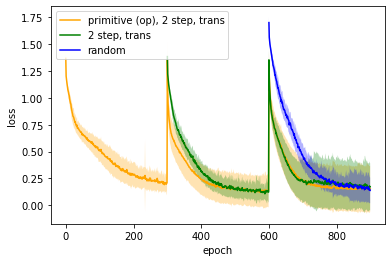

In [37]:
NNplt.plotNN_losses([losses_prim_trans],\
                    labels = ['primitive (op), 2 step, trans'],\
                    colors = ['orange'])

NNplt.plotNN_shifted([losses_trans],\
                     labels = ['2 step, trans'],\
                     colors = ['green'],\
                     shift = 300)

NNplt.plotNN_shifted([losses_rand],\
                     labels = ['random'],\
                     colors = ['blue'],\
                     shift = 600)

In [ ]:
plt,savefig('')